## 3层神经网络

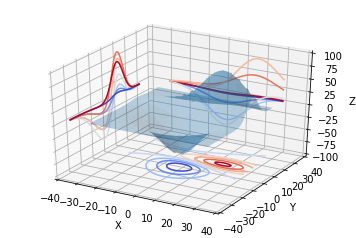

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()


In [2]:
print(plt)

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>


In [3]:
# -*- coding: utf-8 -*-
import numpy as np


def tanh(x):
    return np.tanh(x)


def tanh_deriv(x):
    return 1.0 - np.tanh(x) * np.tanh(x)


def logistic(x):
    return 1 / (1 + np.exp(-x))


def logistic_derivative(x):
    return logistic(x) * (1 - logistic(x))


class NeuralNetwork:
    def __init__(self, layers, activation='tanh'):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv

        self.weights = []
        for i in range(1, len(layers) - 1):
            self.weights.append(
                (2 * np.random.random((layers[i - 1] + 1, layers[i] + 1)) - 1) * 0.25)
            self.weights.append(
                (2 * np.random.random((layers[i] + 1, layers[i + 1])) - 1) * 0.25)

    def fit(self, X, y, learning_rate=0.2, epochs=10000):
        X = np.atleast_2d(X)
        temp = np.ones([X.shape[0], X.shape[1] + 1])
        temp[:, 0:-1] = X
        X = temp
        y = np.array(y)

        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                a.append(self.activation(np.dot(a[l], self.weights[l])))
            error = y[i] - a[-1]
            deltas = [error * self.activation_deriv(a[-1])]

            for l in range(len(a) - 2, 0, -1):
                deltas.append(deltas[-1].dot(self.weights[l].T)
                              * self.activation_deriv(a[l]))
            deltas.reverse()

            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)

    def predict(self, x):
        x = np.array(x)
        temp = np.ones(x.shape[0] + 1)
        temp[0:-1] = x
        a = temp
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a


def main():
    nn = NeuralNetwork([2, 2, 1], 'tanh')
    x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([1, 0, 0, 1])
    nn.fit(x, y, 0.1, 10000)
    for i in [[0, 0], [0, 1], [1, 0], [1, 1]]:
        print(i, nn.predict(i))


if __name__ == '__main__':
    main()


[0, 0] [ 0.99641572]
[0, 1] [  3.92146744e-06]
[1, 0] [ 0.00086446]
[1, 1] [ 0.99635203]


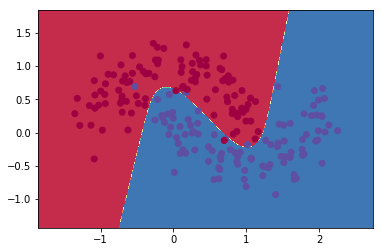

In [1]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt


class Config:
    nn_input_dim = 2
    nn_output_dim = 2
    epsilon = 0.01
    reg_lambda = 0.01


def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y


def visualize(X, y, model):
    plot_decision_boundary(lambda x: predict(model, x), X, y)
    plt.title("Logistic Regression")


def plot_decision_boundary(pred_func, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()


def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    num_examples = len(X)
    np.random.seed(0)
    W1 = np.random.randn(Config.nn_input_dim, nn_hdim) / \
        np.sqrt(Config.nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, Config.nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, Config.nn_output_dim))

    model = {}

    for i in range(0, num_passes):

        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        dW2 += Config.reg_lambda * W2
        dW1 += Config.reg_lambda * W1

        W1 += -Config.epsilon * dW1
        b1 += -Config.epsilon * db1
        W2 += -Config.epsilon * dW2
        b2 += -Config.epsilon * db2

        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    return model


def main():
    X, y = generate_data()
    model = build_model(X, y, 3)
    visualize(X, y, model)


if __name__ == "__main__":
    main()
